# day 3 tutorial

Run the whole notebook by selecting "Restart & Run All" from the "Kernel" menu (above).

**TO RUN LOCALLY users need to install ipywidgets and ipyleaflet and enable the widget extension for jupyter:**
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```
**notes:**
* old code that Yaxing might still want to use is at bottom


In [1]:
import os                            # core py3 
import json
from io import StringIO

import requests                      # data
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import shape

import ipywidgets as wg              # widgets and plotting
import ipyleaflet as mwg 
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from IPython.display import display


%matplotlib inline
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?" # SMV
auth = dict(ORNL_DAAC_USER_NUM=str(32863))             # Jack
hstyle = {"color": "white", "fillOpacity": 0.6}

## SMV Datasets

[*docs/smvdatasets.csv*](docs/smvdatasets.csv) is a copy of the datasets table from the [SMV User Guide](https://daac.ornl.gov/soilmoisture/guide.html). Read it into a `pandas` data frame and display it:

In [2]:
smvds = pd.read_csv("docs/smvdatasets.csv", index_col="dataset", header=0)
smvds

,source,type,units,description,soil_zone,soil_depth,native_res,time_coverage
dataset,,,,,,,,
SoilSCAPE_surface,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"5, 20, 50 cm",point,2011-present
SoilSCAPE_rootzone,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"5, 20, 50 cm",point,2011-present
AirMOSS_in-ground_surface,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
AirMOSS_in-ground_rootzone,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
COSMOS_surface,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,0-30 cm,point,2008-present
COSMOS_rootzone,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,0-30 cm,point,2008-present
AirMOSS_L2_3_surface,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0 cm,surface,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L2_3_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-30cm,rootzone,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L4_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-100cm,rootzone,"0-10, 10-40, 40-100 cm",90-m,2012-2015


Example from file:

In [3]:
df = pd.read_csv("docs/daily-smap-ORNL-DAAC-PccIuo.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)        

df.head(5)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
2012-09-20,;;,;;,;nan;,;7.2;,4.86;7.16;9.2,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-21,;;,;;,;;,;;,9.55;9.6;9.67,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-22,;;,;;,;;,;;,9.34;9.49;9.57,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-23,;;,;;,;;,;;,9.14;9.38;9.52,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-24,;;,;;,;;,;;,8.95;9.27;9.49,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;19.59;,;36.24;,;;,;;


In [4]:
data = df["AirMOSS_L4_rootzone"].str.split(";", n=2, expand=True)
data = data.replace('', np.nan)                                         # set '' to nan
data = data.astype(float)                                               # set all to float
data.columns = ["AirMOSS_L4_rootzone_"+s for s in ["mean","min","max"]]

data.head(5)

,AirMOSS_L4_rootzone_mean,AirMOSS_L4_rootzone_min,AirMOSS_L4_rootzone_max
time,,,
2012-09-20,4.86,7.16,9.20
2012-09-21,9.55,9.60,9.67
2012-09-22,9.34,9.49,9.57
2012-09-23,9.14,9.38,9.52
2012-09-24,8.95,9.27,9.49


plot it:

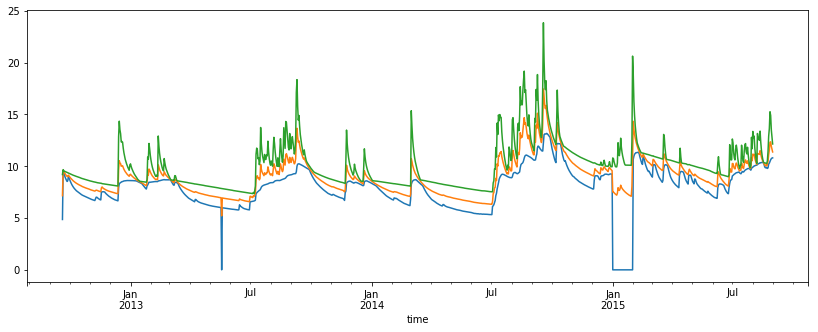

In [5]:
plt.rcParams['figure.figsize'] = [14, 5]

data["AirMOSS_L4_rootzone_mean"].plot()
data["AirMOSS_L4_rootzone_min"].plot()
data["AirMOSS_L4_rootzone_max"].plot()

---------------------------------------------
## Read USFS data from GeoJSON

The original dataset was a shapefile, but we reprojected and saved as GeoJSON using *ogr2ogr* from the GDAL/OGR binaries package available at OSGeo.

Let's open the GeoJSON and reorganize it as a pandas data frame. Read to a dictionary with `json.load` and print the first feature:

In [6]:
with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)

features = shapes["features"]

feat = features[0]
feat["properties"]["id"] = 0
feat["properties"]["style"] = {"weight": 1, "fillOpacity": 0.5}

prop = feat["properties"]
prop

{'OBJECTID': 61,
 'RANGERDIST': '99030501010343',
 'REGION': '03',
 'FORESTNUMB': '05',
 'DISTRICTNU': '01',
 'DISTRICTOR': '030501',
 'FORESTNAME': 'Coronado National Forest',
 'DISTRICTNA': 'Douglas Ranger District',
 'GIS_ACRES': 434025.2,
 'SHAPE_Leng': 3.96360236158,
 'SHAPE_Area': 0.16722952205,
 'Rowid_': 59,
 'FID_1': 60,
 'COUNT': 8159,
 'AREA': 509937500.0,
 'MIN': -79,
 'MAX': 34,
 'RANGE': 113,
 'MEAN': -42.6505699228,
 'STD': 15.107567792,
 'SUM': -347986.0,
 'VARIETY': 96,
 'MAJORITY': -51,
 'MINORITY': -79,
 'MEDIAN': -44,
 'Count_1': 8270.0,
 'Count_2': 8269.0,
 'Count_3': 8270.0,
 'Count_4': 8271.0,
 'Count_5': 8269.0,
 'Count_6': 8257.0,
 'Count_7': 8266.0,
 'Count_8': 8273.0,
 'Count_9': 8272.0,
 'Count_10': 8274.0,
 'Count_11': 8253.0,
 'Count_12': 8256.0,
 'Count_13': 8263.0,
 'Count_14': 8268.0,
 'Count_15': 8262.0,
 'Count_16': 8234.0,
 'Count_17': 8263.0,
 'Count_18': 8268.0,
 'Count_19': 8245.0,
 'Count_20': 8224.0,
 'Count_21': 8272.0,
 'Count_22': 8271.0,
 'C

A feature's properties (AKA attributes) are stored in the "properties" element of the GeoJSON object:

In [7]:
geom = feat["geometry"]         # each feature has a geom
geom

{'type': 'MultiPolygon',
 'coordinates': [[[[-109.2462605499999, 32.05433095000002],
    [-109.24626015999993, 32.05070238000009],
    [-109.24625976999991, 32.04707352000008],
    [-109.2462594, 32.04344467000003],
    [-109.2462586499999, 32.03982309000004],
    [-109.24625792999993, 32.03620154000007],
    [-109.24625717999992, 32.032579690000105],
    [-109.24625642999995, 32.02895783000008],
    [-109.24625542999993, 32.02532931000008],
    [-109.24625441999994, 32.02170079000003],
    [-109.24625341999993, 32.018071990000045],
    [-109.24625241999995, 32.014443200000116],
    [-109.24625163999995, 32.010815260000065],
    [-109.24625083999995, 32.00718729000005],
    [-109.24625005999995, 32.003559080000066],
    [-109.2462492499999, 31.999930830000025],
    [-109.24624877999995, 31.996307030000132],
    [-109.24624830999991, 31.992683230000054],
    [-109.24199216999992, 31.99268452000005],
    [-109.23773602999992, 31.992685700000088],
    [-109.23773580999992, 31.989061420000

Data:

In [8]:
stats = pd.DataFrame({
    "mean": [v for k,v in prop.items() if "MEAN" in k],
    "std": [v for k,v in prop.items() if "STD" in k]})

stats.head(5)

,mean,std
0,-42.650570,15.107568
1,886.231560,569.668620
2,1182.049220,833.106219
3,1269.578235,813.900927
4,1307.410349,909.134138


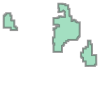

In [9]:
sgeom = shape(geom)     # Shapely.geometry.shape
bnds = sgeom.bounds
cent = sgeom.centroid

sgeom

Leaflet poly:

In [10]:
bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
poly = mwg.GeoJSON(data=feat)
points = mwg.LayerGroup()

m1 = mwg.Map(
    layers=(bmap, poly, points,), 
    center=(cent.y, cent.x), 
    zoom=9)

m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Use a function to generate new map objects so that the state is preserved for maps we've already created:

In [81]:
def getmap(layers, y, x, zoom, scroll=False):
    """ """
    
    b = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
    l = layers if type(layers) is list else [layers]
    m = mwg.Map(layers=([b]+l), center=(y, x), zoom=zoom, scroll_wheel_zoom=scroll)
    
    return(m)

# EASE Grid

Spatial queries to the Soil Moisture Visualizer return data corresponding to 9- by 9-km cells within the EASE grid system. Read about the EASE grid at the NSIDC's web page: https://nsidc.org/data/ease

The next two cells show how to select arrays of EASE grid sample points that fall within an input polygon so that they can be used to submit a series of data requests to the SMV. We will combine everything into one more function (**get_ease**) to use later in our batch processing routine.
      
**Two binary files contain the arrays corresponding to global EASE grid centroid latitudes and longitudes, respectively. Open the two files and read into `numpy` arrays:**

In [12]:
lats = np.fromfile("docs/EASE2_M09km.lats.3856x1624x1.double", dtype=np.float64).flatten() 
lons = np.fromfile("docs/EASE2_M09km.lons.3856x1624x1.double", dtype=np.float64).flatten()
crds = np.dstack((lats,lons))[0]
crds

array([[  84.6564188 , -179.9533195 ],
       [  84.6564188 , -179.85995851],
       [  84.6564188 , -179.76659751],
       ...,
       [ -84.6564188 ,  179.76659751],
       [ -84.6564188 ,  179.85995851],
       [ -84.6564188 ,  179.9533195 ]])

Select a 2-dimensional array of EASE grid centroids using some arbitrary latitude, longitude bounds:

In [13]:
bnds = sgeom.bounds 
bnds

(-110.04372394999993,
 31.382951900000045,
 -108.92062104999994,
 32.13746836000006)

Get the points inside the polygon:

In [14]:
ease = crds[(bnds[1]<lats)&(lats<bnds[3])&(bnds[0]<lons)&(lons<bnds[2])]
ease

array([[  32.08029092, -110.02593361],
       [  32.08029092, -109.93257261],
       [  32.08029092, -109.83921162],
       [  32.08029092, -109.74585062],
       [  32.08029092, -109.65248963],
       [  32.08029092, -109.55912863],
       [  32.08029092, -109.46576763],
       [  32.08029092, -109.37240664],
       [  32.08029092, -109.27904564],
       [  32.08029092, -109.18568465],
       [  32.08029092, -109.09232365],
       [  32.08029092, -108.99896266],
       [  31.99730645, -110.02593361],
       [  31.99730645, -109.93257261],
       [  31.99730645, -109.83921162],
       [  31.99730645, -109.74585062],
       [  31.99730645, -109.65248963],
       [  31.99730645, -109.55912863],
       [  31.99730645, -109.46576763],
       [  31.99730645, -109.37240664],
       [  31.99730645, -109.27904564],
       [  31.99730645, -109.18568465],
       [  31.99730645, -109.09232365],
       [  31.99730645, -108.99896266],
       [  31.91439556, -110.02593361],
       [  31.91439556, -1

Make some points:

In [15]:
mpt = lambda x,y: mwg.CircleMarker(      # map point
    location=(y,x),                       # lat,lon tuple
    radius=7,                             # in pixels
    stroke=False,
    fill_opacity=0.6,
    fill_color="black")

for p in ease:
    points.add_layer(mpt(p[1], p[0]))
    
m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [16]:
points.clear_layers()
point = lambda p: shape({"coordinates": p, "type": "Point"})

for p in ease:
    spt = point([p[1], p[0]])
    if sgeom.contains(spt):
        pt = mpt(p[1], p[0])
        points.add_layer(pt)
        
m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Make a function that includes all of the logic for getting the list of EASE coordinates inside a polygon:

In [17]:
def get_ease(geom):
    """ """
     
    bnds = geom.bounds 
    ease = crds[(bnds[1]<lats)&(lats<bnds[3])&(bnds[0]<lons)&(lons<bnds[2])]
    
    pt = lambda p: shape({"coordinates": p, "type": "Point"})
    inpoly = [[p[0],p[1]] for p in ease if geom.contains(pt([p[1], p[0]]))]
    
    return(inpoly)

# Download a SMV dataset with `requests`
Each request to SMV takes a latitude `&lt` and longitude `&ln`. This request is for (30,-100):       
https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=30&ln=-100&d=smap

In [18]:
lt, ln = ease[0]
url = f"https://daac.ornl.gov/cgi-bin/viz/download.pl?lt={lt}&ln={ln}&d=smap"
r = requests.get(url, cookies=dict(ORNL_DAAC_USER_NUM="10"))
f = StringIO(r.text)

print("\n".join(f.readlines()[0:10]))

Filename: daily-smap-ORNL-DAAC-XXXXXX

Data_Set_Name: Daily soil moisture and ancillary datasets. Data columns are delineated by commas. The values in each column when separated by semicolons represent the daily range as 'min; mean; max'.

Location: 32.0802909170736, -110.02593360995849

Citation: ORNL DAAC. 2017. Soil Moisture Visualizer. ORNL DAAC, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1366





time,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,tmax,tmin,ET,LST_Day,LST_Night,EVI,AirMOSS_in-ground_surface,AirMOSS_in-ground_rootzone,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl

2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;0.72;,;2.92;

2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,

The two functions **txt_to_pd** and **split_pd** do everything we've learned to this point: convert the request response to a text object, then a data frame; and parse the columns of strings into three new columns.

In [19]:
def txt_to_pd(response_text):
    """Parses response.text to data frame with date index."""
    
    f = StringIO(response_text)                      # get file from string
    df = pd.read_csv(f, header=4, index_col="time")  # read to df
    df.index = pd.to_datetime(df.index)              # convert index to dates
    
    return(df)


def split_pd(col):
    """Splits pd column by ; and set all values to float, nan."""
    
    df = col.str.split(";",n=2,expand=True)           # split col by ;
    df = df.replace('', np.nan)                       # set '' to nan
    df = df.astype(float)                             # set all to float
    df.columns = ["mean","min","max"]                 # add column names
    
    return(df)

We use these repeatedly to request an process the entire grid:

In [20]:
df = txt_to_pd(r.text)                                # parse response.text to df
dfs = {col: split_pd(df[col]) for col in df.columns}  # loop over cols and split to dfs

dfs["SMAP_rootzone"].tail(5)

,mean,min,max
time,,,
2019-02-21,21.01,21.07,21.09
2019-02-22,20.99,21.63,22.30
2019-02-23,22.06,22.16,22.27
2019-02-24,21.82,21.94,22.01
2019-02-25,21.61,21.74,21.78


## Reformat SMV data as a netCDF-like `xarray.Dataset`
The function below converts SMV outputs to an `xarray.Dataset`. The structure provided by `xarray` is based on pandas, but is better suited (in my opinion) for organizing data that has a spatial component. 

In [21]:
latatts = dict(
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

lonatts = dict(
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

s = xr.DataArray(data=[1], dims=["sample"])
latarr = xr.DataArray(data=[lt], coords=[s], dims=["sample"], attrs=latatts)
lonarr = xr.DataArray(data=[ln], coords=[s], dims=["sample"], attrs=lonatts)

latarr

<xarray.DataArray (sample: 1)>
array([32.080291])
Coordinates:
  * sample   (sample) int32 1
Attributes:
    standard_name:  latitude
    long_name:      sample latitude
    units:          degrees_north

Now add one more step to the response -> pandas -> split pandas workflow by making an xarray dataset. Print the SMAP_rootzone dataset:

In [22]:
def pd_to_xr(dataset, df):
    """Makes an xr.Dataset from a pandas column (series) and coords."""
    
    a = smvds.loc[dataset].to_dict()
    x = xr.DataArray(df, name=dataset, attrs=a)
    x = x.rename(dict(dim_1="stat"))
    x.attrs["allnan"] = int(np.isnan(np.nanmean(x.data)))
    
    return(x)


ds = {c: pd_to_xr(c,d) for c,d in dfs.items()}
xds = xr.merge(ds.values())
xds = xds.assign_coords(lat=latarr, lon=lonarr)
xds

C:\Apps\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


<xarray.Dataset>
Dimensions:                     (sample: 1, stat: 3, time: 6175)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * stat                        (stat) object 'mean' 'min' 'max'
  * sample                      (sample) int32 1
    lat                         (sample) float64 32.08
    lon                         (sample) float64 -110.0
Data variables:
    SoilSCAPE_surface           (time, stat) float64 nan nan nan ... nan nan nan
    SoilSCAPE_rootzone          (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface        (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_rootzone       (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L4_rootzone         (time, stat) float64 nan nan nan ... nan nan nan
    SMAP_surface                (time, stat) float64 nan nan nan ... 21.82 22.35
    SMAP_rootzone               (time, stat) float64 nan nan nan ... 21.74 21.78
    NEE_mean     

And this is what a single SMV dataset looks like:

In [23]:
xds["SMAP_surface"]

<xarray.DataArray 'SMAP_surface' (time: 6175, stat: 3)>
array([[  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       ...,
       [24.77, 25.96, 27.06],
       [22.31, 23.84, 24.32],
       [20.22, 21.82, 22.35]])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-01 2002-04-02 ... 2019-02-25
  * stat     (stat) object 'mean' 'min' 'max'
Attributes:
    source:         SMAP
    type:           spaceborne
    units:          m3/m3
    description:    Mean vol (%) soil moisture at 0-5cm 
    soil_zone:      surface
    soil_depth:     0-5, 0-100 cm
    native_res:     9000-m 
    time_coverage:  2015-present
    allnan:         0

In some cases it may be advantageous to reorder the dimensions over which the data are arranged. You can transpose the 2-d array with [`xarray.Dataset.transpose`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.transpose.html):

```
xdsT = xds.transpose()
```

### Get the "plottable" datasets
Remember that we added an attribute to each SMV dataset that indicates whether or not the mean\*min\*max array is entirely nodata: *allnan*

Exclude SMV datasets that are entirely nodata using [`xarray.Dataset.filter_by_attrs`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.filter_by_attrs.html#xarray.Dataset.filter_by_attrs):

In [24]:
pds = xds.filter_by_attrs(allnan=0)
pds

<xarray.Dataset>
Dimensions:              (stat: 3, time: 6175)
Coordinates:
  * time                 (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * stat                 (stat) object 'mean' 'min' 'max'
Data variables:
    SMAP_surface         (time, stat) float64 nan nan nan ... 20.22 21.82 22.35
    SMAP_rootzone        (time, stat) float64 nan nan nan ... 21.61 21.74 21.78
    NEE_mean             (time, stat) float64 nan nan nan ... -0.048 0.033 0.114
    GPP_mean             (time, stat) float64 nan nan nan ... 0.694 0.767 0.84
    GRACE_surface_pctl   (time, stat) float64 nan 0.72 nan nan ... nan nan nan
    GRACE_rootzone_pctl  (time, stat) float64 nan 2.92 nan nan ... nan nan nan

We can also filter by any of the other attribute(s) that we assigned from the SMV datasets table:

In [25]:
pds.filter_by_attrs(source="SMAP", soil_zone="rootzone")

<xarray.Dataset>
Dimensions:        (stat: 3, time: 6175)
Coordinates:
  * time           (time) datetime64[ns] 2002-04-01 2002-04-02 ... 2019-02-25
  * stat           (stat) object 'mean' 'min' 'max'
Data variables:
    SMAP_rootzone  (time, stat) float64 nan nan nan nan ... 21.61 21.74 21.78

### Slice/filter using dimension-based criteria
Filter by the *stat* dimension:

In [26]:
pds.sel(stat="mean")

<xarray.Dataset>
Dimensions:              (time: 6175)
Coordinates:
  * time                 (time) datetime64[ns] 2002-04-01 ... 2019-02-25
    stat                 <U4 'mean'
Data variables:
    SMAP_surface         (time) float64 nan nan nan nan ... 24.77 22.31 20.22
    SMAP_rootzone        (time) float64 nan nan nan nan ... 22.06 21.82 21.61
    NEE_mean             (time) float64 nan nan nan nan ... -0.03 0.013 -0.048
    GPP_mean             (time) float64 nan nan nan nan ... 0.427 0.412 0.694
    GRACE_surface_pctl   (time) float64 nan nan nan nan nan ... nan nan nan nan
    GRACE_rootzone_pctl  (time) float64 nan nan nan nan nan ... nan nan nan nan

or the *time* dimension:

In [27]:
time = pds.time.data
print(time[10]); print(time[20])

pds.sel(time=slice(time[10],time[20]))

2002-04-11T00:00:00.000000000
2002-04-21T00:00:00.000000000


<xarray.Dataset>
Dimensions:              (stat: 3, time: 11)
Coordinates:
  * time                 (time) datetime64[ns] 2002-04-11 ... 2002-04-21
  * stat                 (stat) object 'mean' 'min' 'max'
Data variables:
    SMAP_surface         (time, stat) float64 nan nan nan nan ... nan nan nan
    SMAP_rootzone        (time, stat) float64 nan nan nan nan ... nan nan nan
    NEE_mean             (time, stat) float64 nan nan nan nan ... nan nan nan
    GPP_mean             (time, stat) float64 nan nan nan nan ... nan nan nan
    GRACE_surface_pctl   (time, stat) float64 nan nan nan nan ... nan nan nan
    GRACE_rootzone_pctl  (time, stat) float64 nan nan nan nan ... nan nan nan

This feature becomes more useful as you add more dimensions to your dataset. We'll use it to filter across three dimensions once we add more sample locations to this dataset.

In [28]:
pds["SMAP_surface"]

<xarray.DataArray 'SMAP_surface' (time: 6175, stat: 3)>
array([[  nan,   nan,   nan],
       [  nan,   nan,   nan],
       [  nan,   nan,   nan],
       ...,
       [24.77, 25.96, 27.06],
       [22.31, 23.84, 24.32],
       [20.22, 21.82, 22.35]])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-01 2002-04-02 ... 2019-02-25
  * stat     (stat) object 'mean' 'min' 'max'
Attributes:
    source:         SMAP
    type:           spaceborne
    units:          m3/m3
    description:    Mean vol (%) soil moisture at 0-5cm 
    soil_zone:      surface
    soil_depth:     0-5, 0-100 cm
    native_res:     9000-m 
    time_coverage:  2015-present
    allnan:         0

## Make a simple interactive plotting UI
We use the logic above to drive the plotting UI. We can get a list of the attributes to filter by using list comprehension:

In [29]:
source = list(set([pds[d].attrs["source"] for d in pds]))
stype = list(set([pds[d].attrs["type"] for d in pds]))
soil_zone = list(set([pds[d].attrs["soil_zone"] for d in pds]))

print(source); print(stype); print(soil_zone)

['SMAP', 'GRACE']
['spaceborne']
[nan, 'rootzone', 'surface']


GRACE has very few observations, so we don't really need the source filter. And all data are from spaceborne datasets, so the only relevant attribute filter for this dataset is the *soil_zone*:

In [30]:
dates = pds.sel(stat="mean").dropna(dim="time", how="all").time.data
dates = dates.astype('M8[D]')

time_slider = wg.SelectionRangeSlider(
    options=dates, 
    index=(0, len(dates)-1),
    continuous_update=False,
    layout=wg.Layout(width="auto"))

widgets = dict(
    Time=time_slider, 
    By=["None", "year", "month", "week", "day"],
    Zone=['surface', 'rootzone'],
    Mean=True, Min=True, Max=True)

# needs to run twice to switch from inline -->
%matplotlib notebook

Build and display the plot ui:

<IPython.core.display.Javascript object>


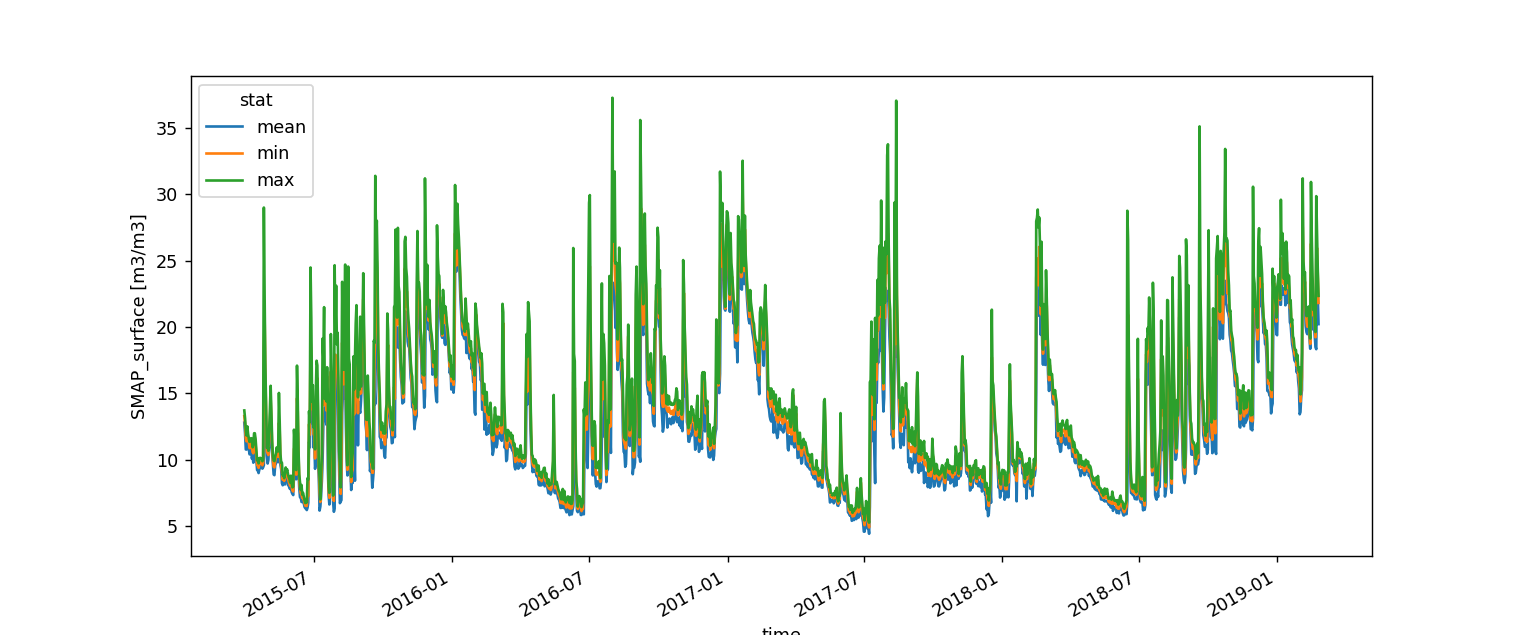

interactive(children=(SelectionRangeSlider(continuous_update=False, description='Time', index=(0, 1427), layou…

In [31]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [12, 5]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


def update(Time, By, Zone, Mean, Min, Max):
    """ """

    stat = [True]*3 if not any([Mean,Min,Max]) else [Mean,Min,Max]
    data = pds.sel(stat=stat)                      # filter by stats
    
    data = data.filter_by_attrs(soil_zone=Zone)    # filter by attributes

    data = data.sel(time=slice(Time[0],Time[1]))   # filter by time;
    
    xaxis = "time" if By == "None" else By         # new plot interval
    if By is not "None":
        data = data.sel(stat="mean")
        data = data.groupby("time."+str(By)).mean()

    ax.clear()                                     # clear plot
    for d in data:                                 # loop over vars
        data[d].plot.line(x=xaxis, ax=ax)          # add line
    fig.canvas.draw()                              # draw 


p = wg.interactive(update, **widgets);
display(p)

## Organize a series of SMV samples into similar structure

The capabilities of xarray aren't obvious until you add a second dimension to the data (excluding the unnecessary *stats* dim). You can do everything we just did with pandas. Let's look at our USFS polygon again with a new map:

In [59]:
points = mwg.LayerGroup()
polys = mwg.LayerGroup(layers=(poly,))
m2 = getmap([polys, points], cent)

m2

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Container for point samples
`Sample(<id>,<lat>,<lon>)`
* id: an integer id unique to the sample within it's input polygon
* lat, lon: latitude, longitude numerics

In [60]:
class Sample(object):

    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        self.id, self.lat, self.lon = i, lat, lon               # id, lat, lon
        self.rurl = url+f"lt={lat}&ln={lon}&d=smap"             # request url
        self.pt = mpt(self.lon, self.lat)                       # a map point layer
        self.on = False                                         # status on/off       

    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)
    
    def toggle(self, event, type, coordinates):
        opac = 0.1 if self.on else 0.6
        self.update(opacity=opac)
        self.on = False if self.on else True
        
    def submit(self):
        """Called by parent. Downloads url. Updates status."""
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = txt_to_pd(self.response.text)                 # read to pandas df
        self.pt.on_click(self.toggle)                           # callback on user click
        self.on = True                                          # toggle on

Use the function we made before `get_ease` to get a list of EASE points inside the polygon, make a Sample for each, and organize inside a data frame. Print the first five rows of the data frame and display the updated map:

In [61]:
samples = []
for i, pt in enumerate(get_ease(sgeom)):
    s = Sample(i, pt[0], pt[1])                # make a Sample instance
    points.add_layer(s.pt)                     # add map pt to points group
    samples.append((i, pt[0], pt[1], s, None)) # append tuple to the list

samples = pd.DataFrame(                        # convert list of tuples to df
    samples, 
    columns=["id", "lat", "lon", "samp", "xr"])

print(samples.head(5)); m2                     # display

   id        lat         lon                                            samp  \
0   0  32.080291 -109.372407  <__main__.Sample object at 0x000001A689EAABA8>   
1   1  32.080291 -109.279046  <__main__.Sample object at 0x000001A689EAA668>   
2   2  31.997306 -110.025934  <__main__.Sample object at 0x000001A689EAA6A0>   
3   3  31.997306 -109.279046  <__main__.Sample object at 0x000001A689EAA978>   
4   4  31.914396 -110.025934  <__main__.Sample object at 0x000001A689EAA4A8>   

     xr  
0  None  
1  None  
2  None  
3  None  
4  None  


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

Add a couple more widgets purely for aesthetics:

In [64]:
n = len(samples.samp)
progress = wg.IntProgress(value=0, min=0, max=n, description="Progress: ", layout=wg.Layout(width="95%"))


def submit_handler(b):
    submit.disabled = True               # disable submit button
    for samp in samples.samp:            # loop over sample pts
        progress.value += 1              # update progress bar
        samp.update(                     # update point style
            stroke=True, 
            color="white", 
            opacity=0.6)
        samp.submit()                    # download the data


submit = wg.Button(description='Submit', button_style='success')
submit.on_click(submit_handler)

download = wg.HBox([submit,progress])
wg.VBox([m2,download])

Hopefully you didn't have any trouble downloading the data. Remember we made the class that binds a map marker to several other items including a pandas data frame that gets created when the sample is retrieved from the SMV.

Check the data frame for sample zero:

In [65]:
samples0 = samples.iloc[0]
print(samples0); samples0.samp.df.tail(5)

id                                                   0
lat                                            32.0803
lon                                           -109.372
samp    <__main__.Sample object at 0x000001A689EAABA8>
xr                                                None
Name: 0, dtype: object


,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl
time,,,,,,,,,,,,,,,,,,,,,
2019-02-21,;;,;;,;;,;;,;;,18.49;19.23;19.62,21.01;21.07;21.09,0.034;0.075;0.116,0.406;0.461;0.517,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2019-02-22,;;,;;,;;,;;,;;,18.33;25.16;29.87,20.99;21.63;22.3,0.11;0.174;0.238,0.324;0.359;0.394,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2019-02-23,;;,;;,;;,;;,;;,24.77;25.96;27.06,22.06;22.16;22.27,-0.03;0.004;0.037,0.427;0.515;0.604,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2019-02-24,;;,;;,;;,;;,;;,22.31;23.84;24.32,21.82;21.94;22.01,0.013;0.05;0.087,0.412;0.493;0.574,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2019-02-25,;;,;;,;;,;;,;;,20.22;21.82;22.35,21.61;21.74;21.78,-0.048;0.033;0.114,0.694;0.767;0.84,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;


This looks familiar. Use the steps that we learned before to convert to an xarray dataset:

In [66]:
s0 = xr.DataArray(data=[samples0.id], dims=["sample"])
y0 = xr.DataArray(data=[samples0.lat], coords=[s0], dims=["sample"], attrs=latatts)
x0 = xr.DataArray(data=[samples0.lon], coords=[s0], dims=["sample"], attrs=lonatts)

df0 = samples0.samp.df                                  # get the sample df
dfs0 = {col: split_pd(df0[col]) for col in df0.columns} # loop over cols and split to dfs
ds0 = {c: pd_to_xr(c,d) for c,d in dfs0.items()}        # make xr datasets for each smv
xds0 = xr.merge(ds0.values())                           # merge to one xr dataset
xds0 = xds0.assign_coords(lat=y0, lon=x0)               # add coordinate arrays sample 
xds0

C:\Apps\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


<xarray.Dataset>
Dimensions:                     (sample: 1, stat: 3, time: 6175)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * stat                        (stat) object 'mean' 'min' 'max'
  * sample                      (sample) int64 0
    lat                         (sample) float64 32.08
    lon                         (sample) float64 -109.4
Data variables:
    SoilSCAPE_surface           (time, stat) float64 nan nan nan ... nan nan nan
    SoilSCAPE_rootzone          (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface        (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_rootzone       (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L4_rootzone         (time, stat) float64 nan nan nan ... nan nan nan
    SMAP_surface                (time, stat) float64 nan nan nan ... 21.82 22.35
    SMAP_rootzone               (time, stat) float64 nan nan nan ... 21.74 21.78
    NEE_mean     

While we're at it, wrap all of that up in a function to apply to all of the samples:

In [67]:
def get_sample_xr(srow):
    """ """
    
    # get sample, lat, lon xr arrays
    s = xr.DataArray(data=[srow.id], dims=["sample"])
    y = xr.DataArray(data=[srow.lat], coords=[s], dims=["sample"], attrs=latatts)
    x = xr.DataArray(data=[srow.lon], coords=[s], dims=["sample"], attrs=lonatts)

    df = srow.samp.df                                    # get the sample df
    dfs = {col: split_pd(df[col]) for col in df.columns} # loop over cols and split to dfs
    ds = {c: pd_to_xr(c,d) for c,d in dfs.items()}       # make xr datasets for each smv
    xds = xr.merge(ds.values())                          # merge to one xr dataset
    xds = xds.assign_coords(lat=y, lon=x)                # add coordinate arrays
    
    return(xds)
    

for ix, row in samples.iterrows():                # loop over samples df
    samples.at[ix, "xr"] = get_sample_xr(row)     # add xr dataset to col
    
samples

C:\Apps\Python\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


,id,lat,lon,samp,xr
0,0,32.080291,-109.372407,<__main__.Sample object at 0x000001A689EAABA8>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
1,1,32.080291,-109.279046,<__main__.Sample object at 0x000001A689EAA668>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
2,2,31.997306,-110.025934,<__main__.Sample object at 0x000001A689EAA6A0>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
3,3,31.997306,-109.279046,<__main__.Sample object at 0x000001A689EAA978>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
4,4,31.914396,-110.025934,<__main__.Sample object at 0x000001A689EAA4A8>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
5,5,31.914396,-109.932573,<__main__.Sample object at 0x000001A689EAA748>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
6,6,31.914396,-109.372407,<__main__.Sample object at 0x000001A68CAED780>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
7,7,31.914396,-109.279046,<__main__.Sample object at 0x000001A68CAEDE48>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
8,8,31.914396,-109.185685,<__main__.Sample object at 0x000001A689E13B38>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."
9,9,31.831558,-109.932573,<__main__.Sample object at 0x000001A68CAED5C0>,"[SoilSCAPE_surface, SoilSCAPE_rootzone, AirMOS..."


Check sample ten:

In [68]:
samples.iloc[10].xr

<xarray.Dataset>
Dimensions:                     (sample: 1, stat: 3, time: 6175)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * stat                        (stat) object 'mean' 'min' 'max'
  * sample                      (sample) int32 10
    lat                         (sample) float64 31.83
    lon                         (sample) float64 -109.4
Data variables:
    SoilSCAPE_surface           (time, stat) float64 nan nan nan ... nan nan nan
    SoilSCAPE_rootzone          (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface        (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_rootzone       (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L4_rootzone         (time, stat) float64 nan nan nan ... nan nan nan
    SMAP_surface                (time, stat) float64 nan nan nan ... 21.82 22.35
    SMAP_rootzone               (time, stat) float64 nan nan nan ... 21.74 21.78
    NEE_mean    

Hopefully, if we organized the data correctly, we can concatenate along the sample dimension:

In [69]:
xds0 = xr.concat(samples.xr.tolist(), "sample")
xds0

<xarray.Dataset>
Dimensions:                     (sample: 23, stat: 3, time: 6175)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * stat                        (stat) object 'mean' 'min' 'max'
  * sample                      (sample) int64 0 1 2 3 4 5 ... 17 18 19 20 21 22
    lat                         (sample) float64 32.08 32.08 32.0 ... 31.5 31.42
    lon                         (sample) float64 -109.4 -109.3 ... -109.0 -109.0
Data variables:
    SoilSCAPE_surface           (sample, time, stat) float64 nan nan ... nan nan
    SoilSCAPE_rootzone          (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_surface        (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_rootzone       (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L4_rootzone         (sample, time, stat) float64 nan nan ... nan nan
    SMAP_surface                (sample, time, stat) float64 nan nan ... 22.35
    SMAP_rootzon

Save as a netCDF. The dataset needs another variable and some special attributes to comply with CF (explain CF):
* a variable that describes the sequence that makes up the sample dimension
* a dataset-level attribute that inidcates the dataset's *featureType*

In [70]:
# loop over sample dim sequence and make strings like: "sample##"
sample_name_data = ["sample"+("%02d" % s) for s in xds0.sample.data]

xds0["sample_name"] = xr.DataArray(        # make an xr array
    data=sample_name_data, 
    dims=["sample"], 
    attrs=dict(                            # cf attributes
        long_name="sample name", 
        cf_role="timeseries_id"))

xds0.attrs.update({
    "convention": "CF-1.6", 
    "featureType": "timeSeries",
    "source": "Soil Moisture Visualizer",
    "institution": "Oak Ridge National Laboratory Distributed Active Archive Center"})

xds0

<xarray.Dataset>
Dimensions:                     (sample: 23, stat: 3, time: 6175)
Coordinates:
  * sample                      (sample) int64 0 1 2 3 4 5 ... 17 18 19 20 21 22
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * stat                        (stat) object 'mean' 'min' 'max'
    lat                         (sample) float64 32.08 32.08 32.0 ... 31.5 31.42
    lon                         (sample) float64 -109.4 -109.3 ... -109.0 -109.0
Data variables:
    SoilSCAPE_surface           (sample, time, stat) float64 nan nan ... nan nan
    SoilSCAPE_rootzone          (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_surface        (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_rootzone       (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L4_rootzone         (sample, time, stat) float64 nan nan ... nan nan
    SMAP_surface                (sample, time, stat) float64 nan nan ... 22.35
    SMAP_rootzon

Save with [`xarray.Dataset.to_netcdf`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html#xarray.Dataset.to_netcdf):

In [71]:
xds0.to_netcdf("23samples.nc")

## Extend the plotting UI
We probably have more options for filters with a dataset this size. Let's see:

In [72]:
xpds = xds0.filter_by_attrs(allnan=0)
xpds

<xarray.Dataset>
Dimensions:              (sample: 23, stat: 3, time: 6175)
Coordinates:
  * time                 (time) datetime64[ns] 2002-04-01 ... 2019-02-25
  * sample               (sample) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22
    lat                  (sample) float64 32.08 32.08 32.0 ... 31.5 31.5 31.42
    lon                  (sample) float64 -109.4 -109.3 -110.0 ... -109.0 -109.0
  * stat                 (stat) object 'mean' 'min' 'max'
Data variables:
    SMAP_surface         (sample, time, stat) float64 nan nan ... 21.82 22.35
    SMAP_rootzone        (sample, time, stat) float64 nan nan ... 21.74 21.78
    NEE_mean             (sample, time, stat) float64 nan nan ... 0.033 0.114
    GPP_mean             (sample, time, stat) float64 nan nan nan ... 0.767 0.84
    GRACE_surface_pctl   (sample, time, stat) float64 nan 0.72 nan ... nan nan
    GRACE_rootzone_pctl  (sample, time, stat) float64 nan 2.92 nan ... nan nan
Attributes:
    convention:   CF-1.6
    featureTy

## Crap! No other SMV datasets for this poly. I guess we should let users sample more

Make a better downloader?

## better colors
1. use [`numpy.linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) to make an array of evenly-spaced values between 0-1 
2. map values to **Set3** in [`matplotlib.cm`](https://matplotlib.org/api/cm_api.html) | [colormap reference](https://matplotlib.org/gallery/color/colormap_reference.html)
3. convert to hexadecimal with [`matplotlib.colors.to_hex`](https://matplotlib.org/api/_as_gen/matplotlib.colors.to_hex.html#matplotlib.colors.to_hex)


In [73]:
cspace = np.linspace(0.0, 1.0, len(features)) # 1
rgb = cm.Set3(cspace)                         # 2
cols = [colors.to_hex(c[0:3]) for c in rgb]   # 3

cols

['#8dd3c7',
 '#ffffb3',
 '#bebada',
 '#80b1d3',
 '#fdb462',
 '#b3de69',
 '#d9d9d9',
 '#bc80bd',
 '#ccebc5',
 '#ffed6f']

MAybe give them the option to import shapefile?
```
with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)
features = shapes["features"]
```


In [184]:
m1, m2, s0, df0, dfs0, xds0, samples = None, None, None, None, None, None, None

polys = mwg.LayerGroup()
points = mwg.LayerGroup()
m3 = getmap([polys,points], 32.75, -109, 7, scroll=True)

submit = wg.Button( 
    description='Submit', 
    disabled=True, 
    button_style='success')

progress = wg.IntProgress(
    description="Progress: ", 
    layout=wg.Layout(width="95%"))

ui = wg.VBox([
    m3, 
    wg.HBox([submit, progress])])

In [185]:
def mgeojson(i, feat, col):
    p = feat["properties"]
    p["id"] = i
    p["style"] = {
        "color": col, 
        "fillColor": col, 
        "weight": 1, 
        "fillOpacity": 0.4}
    feat["properties"] = p
    lyr = mwg.GeoJSON(
        data=feat, 
        hover_style={
            "color": "white", 
            "fillOpacity": 0.8})
    return(lyr)


class Layer(object):

    def __init__(self, i, feat, col=None):
        """Inits with id,lat,lon; makes request string, map point."""
        self.id = i
        self.feat = feat
        
        self.geom = feat["geometry"]
        self.sgeom = shape(self.geom)
        self.cent = self.sgeom.centroid
        self.ease = get_ease(self.sgeom)
        
        self.samples, self.points = {}, mwg.LayerGroup()
        for i, pt in enumerate(get_ease(sgeom)):
            self.samples[i] = Sample(i, pt[0], pt[1])  
            self.points.add_layer(self.samples[i].pt)

        self.layer = mgeojson(i, feat, col)
        self.layer.on_click(self.toggle)
        self.on = False                          # status on/off
        
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.layer, arg, val)
    
    def toggle(self, **kwargs):
        """Routine for when a new USFS polygon is selected."""
        if list(kwargs.keys()) != ['event', 'properties']: # check event; skip bmap
            return(None)
        m3.center = (self.cent.y, self.cent.x)             # center map
        m3.zoom = 9                                        # zoom map
        submit.disabled = False

In [186]:
layers = {}
for i, feat in enumerate(features):
    layers[i] = Layer(i, feat, col=cols[i])
    polys.add_layer(layers[i].layer)
    points.add_layer(layers[i].points)

In [187]:
ui

In [ ]:
   prop = feat["properties"]
    mean = [v for k,v in prop.items() if "MEAN" in k]
    std = [v for k,v in prop.items() if "STD" in k]
    stats = pd.DataFrame({"mean": mean, "std": std})
    
    
    layer.on_click(updatepoly)
    polys.add_layer(layer)
    
    geom = feat["geometry"]
    sgeom = shape(geom)
    bnds = sgeom.bounds
    cent = sgeom.centroid
    ease = get_ease(sgeom)
    
    samples, points = [], mwg.LayerGroup()
    for i, pt in enumerate(get_ease(sgeom)):
        s = Sample(i, pt[0], pt[1])                # make a Sample instance
        points.add_layer(s.pt)
        samples.append((i, pt[0], pt[1], s, None)) # append tuple to the list  
    samples = pd.DataFrame(                        # convert list of tuples to df
        samples, 
        columns=["id", "lat", "lon", "samp", "xr"])


In [ ]:


def updatepoly(**kwargs): 
    """Routine for when a new USFS polygon is selected."""
    if list(kwargs.keys()) != ['event', 'properties']: # check event; skip bmap
         return(None)
    id = int(kwargs["properties"]["id"])               # set selected poly id
    poly = polydf.iloc[id]                             # get row for selected
    
    points.clear_layers()
    for p in poly["points"].layers:
        points.add_layer(p)
    m3.center = (poly["lat"], poly["lon"])             # center map
    m3.zoom = 9                                        # zoom map
    submit.disabled = False                            # enable submit bttn


layers = {}
for i, feat in enumerate(features):
    feat["properties"]["id"] = i
    feat["properties"]["style"] = {
            "color": cols[i], 
            "fillColor": cols[i], 
            "weight": 1, 
            "fillOpacity": 0.4}
    
    prop = feat["properties"]
    mean = [v for k,v in prop.items() if "MEAN" in k]
    std = [v for k,v in prop.items() if "STD" in k]
    stats = pd.DataFrame({"mean": mean, "std": std})
    
    layer = mwg.GeoJSON(data=feat, hover_style={"color": "white", "fillOpacity": 0.8})
    layer.on_click(updatepoly)
    polys.add_layer(layer)
    
    geom = feat["geometry"]
    sgeom = shape(geom)
    bnds = sgeom.bounds
    cent = sgeom.centroid
    ease = get_ease(sgeom)
    
    samples, points = [], mwg.LayerGroup()
    for i, pt in enumerate(get_ease(sgeom)):
        s = Sample(i, pt[0], pt[1])                # make a Sample instance
        points.add_layer(s.pt)
        samples.append((i, pt[0], pt[1], s, None)) # append tuple to the list  
    samples = pd.DataFrame(                        # convert list of tuples to df
        samples, 
        columns=["id", "lat", "lon", "samp", "xr"])

    layers.append((i, feat, cent.x, cent.y, ease, stats, layer, points, None))

polydf = pd.DataFrame(
    layers, 
    columns=["id", "feat", "lon", "lat", "ease", "stats", "layer", "points", "samples"])

In [ ]:
class Layer(object):
    
    def __init__(self, ):
        self.ui = ui
        self.map =widgets[0]                        # map widget
        self.submit = widgets[1]                    # submit button
        self.pbar = widgets[2]                      # progress bar
        self.chkbx = widgets[3]                     # plot checkboxes

        self.points = mwg.LayerGroup()              # make empty container for samples
        self.map.add_layer(self.points)             # and add to map widget
        self.submit.on_click(self.submit_handler)   # set submit bttn callback

        self.df = get_spatialdf(geojson)# make spatial df summarizing features        
        
        for ix, row in self.df.iterrows():          # loop over rows
            poly = row["poly"]                      # get layer poly
            poly.on_click(self.lyr_click_handler)   # set callback
            self.map.add_layer(poly)                # add to map

        # get other metadata about datasets and SMV in general; FLUXNET breaks???
        self.datasets = [d for d in smvds.index.tolist() if "FLUXNET" not in d]

    def lyr_click_handler(self, **kwargs): 
        """Routine for when a new USFS polygon is selected."""
        if list(kwargs.keys()) != ['event', 'properties']: # check event; skip bmap
             return(None)

        self.id = int(kwargs["properties"]["id"])          # set selected poly id
        row = self.df.iloc[self.id]                        # get row for selected
        cent = row["centroid"]                             # get centroid
        
        self.map.center = (cent.y, cent.x)                 # center map
        self.map.zoom = 9                                  # zoom map

        if not row["data"]:                                # if first select;
            ease = row["ease_pts"]                         #  make SMVSample obj
            self.data = {}                                 #  for each sample pt
            for i, c in enumerate(ease):                   # loop over EASE pts
                self.data[i] = SMVSample(i, c[1], c[0])    #  add SMVSample to d
            self.df.at[self.id, "data"] = self.data        #  and data link to df
        else:                                              # else
            self.data = row["data"]                        #  load data from before
            
        self.submit.disabled = False                       # enable submit bttn
        self.points.clear_layers()                         # clear ease grid pts
        for sample in self.data.values():                  # loop and add to map 
            self.points.add_layer(sample.pt)

    def submit_handler(self, b):
        """Resets UI and sends requests to SMV when new submit."""
        self.pbar.min = 0                                  # reset progress bar
        self.pbar.max = len(self.points.layers)            #
        self.pbar.value = 0                                #
        self.submit.disabled = True                        # disable submit button
        for sample in self.data.values():                  # loop over sample pts
            self.pbar.value += 1                           # update progress bar
            sample.update_pt(                              # update style
                stroke=True, color="white", opacity=0.6)   #
            sample.submit()                                # download the data

        self.xr = xrdataset(self.data, self.datasets)      # merge all data as xr
        for label, group in self.chkbx.items():            # enable plotting ui
            for box in group:
                box.disabled = False
    
    def plotter(self, dataset, clear=True):
        """ """
        on = [self.data.values()]
        #select = []

In [ ]:
        for i, feat in enumerate(features):         # loop over features

            feat = add_props(feat, i, cols[i])      # add id and style props
            geom = feat["geometry"]                 # get the site's geometry
            shp = shape(geom)                       # make a shapely geometry object
            
            df["id"].append(i)                      # add id to dict
            df["feature"].append(feat)              # add updated feature to dict
            df["centroid"].append(shp.centroid)     # get the centroid of the site
            df["ease_pts"].append(get_ease(shp))    # get contained ease grid points
            df["poly"].append(mwg.GeoJSON(          # make poly layer
                data=feat,                          # GeoJSON feature as dict
                hover_style={
                    "color": "white",               # show white on hover
                    "fillOpacity": 0.8}))           # increase opac on hover
            df["color"].append(cols[i])             # add color to dict
            df["data"].append(None)                 # add place for data to dict

        return(pd.DataFrame(df))


In [ ]:

source = list(set([xpds[d].attrs["source"] for d in xpds]))
stype = list(set([xpds[d].attrs["type"] for d in xpds]))
soil_zone = list(set([xpds[d].attrs["soil_zone"] for d in xpds]))
units = list(set([xpds[d].attrs["units"] for d in xpds]))

print(source); print(stype); print(soil_zone); print(units)

In [ ]:
list(xds0)
xds0["AirMOSS_L4_rootzone"]

In [ ]:


with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)

features = shapes["features"]

feat = features[0]
feat["properties"]["id"] = 0
feat["properties"]["style"] = {"weight": 1, "fillOpacity": 0.5}
prop = feat["properties"]
geom = feat["geometry"]         # each feature has a geom
stats = pd.DataFrame({
    "mean": [v for k,v in prop.items() if "MEAN" in k],
    "std": [v for k,v in prop.items() if "STD" in k]})
sgeom = shape(geom)     # Shapely.geometry.shape
bnds = sgeom.bounds
cent = sgeom.centroid
ease = get_ease(sgeom)

In [ ]:
source = list(set([pds[d].attrs["source"] for d in pds]))
stype = list(set([pds[d].attrs["type"] for d in pds]))
soil_zone = list(set([pds[d].attrs["soil_zone"] for d in pds]))

print(source); print(stype); print(soil_zone)

This function uses the logic above to select an array of coordinates within bounding extent of the polygon:

In [ ]:
point = lambda p: shape({"coordinates": p, "type": "Point"})

def get_ease(geom):
    """ """
    bnds = geom.bounds 
    ease = crds[(bnds[1]<lats)&(lats<bnds[3])&(bnds[0]<lons)&(lons<bnds[2])]
    inpoly = [p for p in ease if geom.contains(point([p[1], p[0]]))]
    return(inpoly)

Re-organize the properties a bit:

In [ ]:

site = {k:v for k,v in prop.items() if statcheck(k)}

print(json.dumps(site, indent=2))

In [ ]:

group = mwg.LayerGroup()

mapw = mwg.Map(
    layers=(bmap, group),            # basemap; poly container
    center=(33, -109),               # map center
    zoom=7,                          # zoom level
    scroll_wheel_zoom=True)          # scrollable

Get the stats columns as a table:

Read an example file from txt:

The columns have three values separated by semicolons: mean, min, max. Split them with str.split:

In [ ]:
def getmap(layers, cent):
    b = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
    l = l if type(layers) is list else [layers]
    m = mwg.Map(layers=([b]+l), center=(cent.y, cent.x), zoom=9)
    return(m)

m1 = getmap(poly, cent)


In [ ]:

data.plot()

## Beef up the Sample class

In [ ]:
class Sample(object):

    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        self.id, self.lat, self.lon = i, lat, lon    # id, lat, lon
        self.rurl = url+f"lt={lat}&ln={lon}&d=smap"  # request url
        self.pt = mpt(self.lon, self.lat)            # a map point layer
        self.on = False                              # status on/off       

    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)
    
    def toggle(self, event, type, coordinates):
        opac = 0.1 if self.on else 0.6
        self.update(opacity=opac)
        self.on = False if self.on else True
        
    def submit(self):
        """Called by parent. Downloads url. Updates status."""
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = txt_to_pd(self.response.text)                 # read to pandas df
        self.on = True                                          # toggle on
        self.pt.on_click(self.toggle)                           # callback on user click

The `xarray.Dataset` is easily saved to netCDF:

In [ ]:
ds["SMAP_rootzone"].to_netcdf("SMAP_rootzone-ex.nc")  # save to a netcdf
r, df, c, ds = None, None, None, None     # remove old data

The app that we build at the end of the tutorial will be driven by data stored in one big `xarray.Dataset`, arranged with dozens of requests arranged in a gridded system described below. The function below allows us to merge a list of datasets along the **sample** dimension:

In [ ]:
s = xr.DataArray(data=[i], dims=["sample"])
y = xr.DataArray(data=[lat], coords=[s], dims=d, attrs=latatts)
x = xr.DataArray(data=[lon], coords=[s], dims=d, attrs=lonatts)

def get_xr(df, i, lat, lon): 
    """ """
    sc = {c: split_pd(df[c]) for c in df}
    ds = {c: pd_to_xr(c,d,[s,sn,x,y]) for c,d in sc.items()}
    return(ds)


def xrdataset(samples, datasets):
    """ """
    bydataset = []                                  # xr dataset for each dataset
    for d in datasets:                              # loop over dataset names
        xrds = [s[d] for s in samples.values()]     # get dataset for all samples
        bydataset.append(xr.concat(xrds, "sample")) # concat all along sample dim
    return(xr.merge(bydataset))                     # merge all concat'd datasets

---------------------------------
## Building a Jupyter app around the SMV

What we need:
* container for point samples
* class to manage dynamic info
* pandas data frame to hold all the data we just took from the USFS site features
* widgets

### Container for point samples
`Sample(<id>,<lat>,<lon>)`
* id: an integer id unique to the sample within it's input polygon
* lat, lon: latitude, longitude numerics

In [ ]:
class Sample(object):

    def __init__(self, *args):
        """Inits with id,lat,lon; makes request string, map point."""
        self.i, self.lat, self.lon = args                        # id, lat, lon
        self.rurl = url + f"lt={self.lat}&ln={self.lon}&d=smap"  # request url
        
        self.pt = mwg.CircleMarker(                              # map point
            location=(self.lat, self.lon),  # lat,lon tuple
            radius=7,                       # in pixels
            stroke=False,
            fill_opacity=0.6,
            fill_color="black")
        
    def update_pt(self, **kwargs):
        """Called by submit. Takes dict of point properties, updates self.pt."""
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)        
        
    def toggle_pt(self, event, type, coordinates):
        """ """
        if self.on:
            self.on = False
            self.update_pt(opacity=0.1)
        else:
            self.on = True
            self.update_pt(opacity=0.6)  

    def submit(self):
        """Called by parent. Downloads url. Gets dict of xr.Datasets, 1/smv dataset."""
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = txt_to_pd(self.response.text)                 # read to pandas df
        self.xr = get_xr(self.df, self.i, self.lat, self.lon)   # get xarray 
        
        self.pt.on_click(self.toggle_pt) 
        self.on = True                      # has on/off status depending on input

        
# example use:
easept = selection[0]
sample = Sample(0, easept[0], easept[1])    # Sample instance
sample.submit()                             # send request to SMV and process download

sample.xr['SMAP_rootzone'] # print SMAP_rootzone dataset

### Data frame for USFS sites 

One more thing before we make the data frame. Steps to get nice colors for the map polygons:
1. use [`numpy.linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) to make an array of evenly-spaced values between 0-1 
2. map values to **Set3** in [`matplotlib.cm`](https://matplotlib.org/api/cm_api.html) | [colormap reference](https://matplotlib.org/gallery/color/colormap_reference.html)
3. convert to hexadecimal with [`matplotlib.colors.to_hex`](https://matplotlib.org/api/_as_gen/matplotlib.colors.to_hex.html#matplotlib.colors.to_hex)


In [ ]:
cspace = np.linspace(0.0, 1.0, len(features)) # 1
rgb = cm.Set3(cspace)                         # 2
cols = [colors.to_hex(c[0:3]) for c in rgb]   # 3

cols

https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.to_html.html

Loop over each feature, make map layers and collect info into a data frame:

In [ ]:
pstyle = lambda c,w,f: {"color":c, "fillColor":c, "weight":w, "fillOpacity":f}
hstyle = {"color": "white", "fillOpacity": 0.8}

layers = []

for i, feat in enumerate(features):
    geom = feat["geometry"]
    shp = shape(geom)       
    cent = shp.centroid     
    ease = get_ease(shp)
    col = cols[i]
    
    prop = feat["properties"]
    site = {k:v for k,v in prop.items() if statcheck(k)}
    stats = pd.DataFrame({
        "mean": [v for k,v in prop.items() if "MEAN" in k], 
        "std": [v for k,v in prop.items() if "STD" in k]})
    
    samples = [Sample(j,p[1],p[0]) for j,p in enumerate(ease)]
    pts = [s.pt for s in samples]
    grp = mwg.LayerGroup(layers=tuple(pts))
    
    feat["properties"]["id"] = i
    feat["properties"]["style"] = pstyle(col,1,0.5)
    poly = mwg.GeoJSON(data=feat,hover_style=hstyle)
    
    layers.append((feat, site, stats, cent, ease, col, poly, samples, pts, grp))

df = pd.DataFrame(layers)
df.columns = [
    "feat", 
    "site", 
    "stats", 
    "cent", 
    "ease", 
    "col", 
    "poly", 
    "samples", 
    "pts", 
    "grp"]

df.head(5)

* `ipyleaflet` map widget
* submit button to begin sending series of requests to the SMV
* progress bar to monitor progress of the requests

In [ ]:
bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
group = mwg.LayerGroup()

mapw = mwg.Map(
    layers=(bmap, group),            # basemap; poly container
    center=(33, -109),               # map center
    zoom=7,                          # zoom level
    scroll_wheel_zoom=True)          # scrollable

submit = wg.Button(
    description='Submit', 
    disabled=True, 
    button_style='success')

progress = wg.IntProgress(
    description="Progress: ", 
    layout=wg.Layout(width="95%"))

ui = wg.VBox([mapw,wg.HBox([submit,progress])])

(ui, group, (mapw, submit, progress))

### Class to manage dynamic info
**button_click_handler** reacts to user clicking the submit button by iterating over the sample EASE points resulting from the **layer_click_handler** above and sends the download requests to the SMV and converts text to xarray:

In [ ]:
datasets = [d for d in smvds.index.tolist() if "FLUXNET" not in d] # fluxnet broken??


class App(object):

    def __init__(self, df, ui):
        self.df = df
        self.ui, self.group, widgets = ui
        self.map, self.submit, self.progress = widgets
        for poly in self.df["poly"]:              # loop over rows
            poly.on_click(self.layer_update)      #   set callback
            self.group.add_layer(poly)              #   add to layer group 
        self.submit.on_click(self.submit_handler) # set submit bttn callback 
        self.points = None
        
    def layer_update(self, **kwargs): 
        """Routine for when a new USFS polygon is selected."""
        if list(kwargs.keys()) != ['event', 'properties']: # check event; skip bmap
             return(None)

        self.id = int(kwargs["properties"]["id"]) # set selected poly id
        self.site = self.df.iloc[self.id]         # get row for selected
        self.pts = self.site["pts"]
        self.samples = self.site["samples"]       # list of class Sample
        
        cent = self.site["cent"]
        self.map.center = (cent.y, cent.x)        # center map
        self.map.zoom = 9                         # zoom map
            
        self.submit.disabled = False              # enable submit bttn
        if self.points:
            self.map.remove_layer(self.points)    # clear ease grid pts
        
        self.points = self.site["grp"]            # add to map 
        self.map.add_layer(self.points)      

            
    def submit_handler(self, b):
        """Resets UI and sends requests to SMV when new submit."""
        self.pbar.min = 0                         # reset progress bar
        self.pbar.max = len(self.points.layers)   #
        self.pbar.value = 0                       #
        self.submit.disabled = True               # disable submit button
        
        for samp in self.samples:                 # loop over sample pts
            self.sub[1].value += 1                # update progress bar
            samp.update_pt(                       # update style
                stroke=True, color="white", opacity=0.6)
            samp.submit()                         # download the data
            #samp.pt.on_click(sample_update)      # do something to plots
            
        self.xr = xrdataset(self.data, datasets)  # merge all data as x        
    
    #def sample_update(self): ...
    #def plotter(self, dataset, clear=True): ...

# Put it all the steps together; display the app
The classes above provide all of the functionality of the app. The three steps below 

Open the input GeoJSON and get data frame structure we created before.

In [ ]:
app = App(df)
app.ui

# Display the UI

**Instructions:**
1. Run the following cell.          
2. Select a USFS polygon on the map; an array of EASE grid points will be displayed that represent the locations of the data available through the Soil Moisture Visualizer API.               
3. Click *Submit*; wait for the downloads to process.            
4. Explore the data interactively.            
    * Click a point to toggle the associated data on and off; this adds/removes the data for all visualizations.
    * Double click a point to disable all other points.

In [ ]:
appdata.ui

## plotter class

In [ ]:
%matplotlib notebook

def exnan(variable):
    return(np.isnan(np.nanmean(variable)))

def filt(data, dim=None, var=None, att=None):
    if dim: data = data.isel(**dim)             # if sample, filter with isel()
    if var: data = data[var]                    # if variables, select   
    if att: data = data.filter_by_attrs(**att)  # if attributes, filter with filter_by_attrs()
    return(data)

def flat(variable):
    """ """
    if len(variable.dims)>1:
        return(variable.mean(dim="sample"))
    else:
        return(variable)

# ---------------------------------------------------------------------------------


class Plotting(object):
    
    def __init__(self, xr, chkbx, samples):
        self.xr = xr
        self.chk = chkbx
        self.samp = samples
        
        self.smv = [v for v in list(self.xr) if "source" in self.xr[v].attrs]
        
        self.chkbools = {} # add updater callback to all checkboxes; build bools table
        for group in self.chk:
            self.chkbools[group] = {}
            for dataset in self.chk[group]:
                dataset.observe(self.att_updater, names='value')
                desc = dataset.description
                self.chkbools[group][desc] = dataset.value
                
        self.sampbools = [] # add updater callback for pt clicks
        for i, sample in self.samp.items():
            self.sampbools.append((i, sample.lat, sample.lon, sample.on))
            sample.pt.on_click(self.samp_updater)
        self.sampbools = pd.DataFrame(self.sampbools, columns=["id","y", "x","on"])
        self.sampbools = self.sampbools.set_index("id")


    def samp_updater(self, event, type, coordinates):
        """ """
        id = self.sampbools.loc[
            (self.sampbools["y"]==coordinates[0]) & 
            (self.sampbools["x"]==coordinates[1])]
        if self.sampbools[id]["on"]:
            self.sampbools.at[id, "on"] = False
        else:
            self.sampbools.at[id, "on"] = True
            
        t = []
        for i, row in self.sampbools.iterrows():
            if row["on"]:
                t.append(i)
        self.dimsbool = dict(sample=t)
        self.plot()
        

    def att_updater(self, change):

        # update bools table     --->>> attributes
        attribute_filter=dict()
        desc = change.owner.description
        for g in self.chkbools:
            for d in self.chkbools[g]:
                if d==desc:
                    self.chkbools[g][d] = change.new
        #source = [a for a,v in self.chkbools["source"] if not v]
        #units = [a for a,v in self.chkbools["units"] if not v]
        #native_res = [a for a,v in self.chkbools["native_res"] if not v]
        #type = [a for a,v in self.chkbools["type"] if not v]
        #soil_zone = [a for a,v in self.chkbools["soil_zone"] if not v] <<<---

         
    def plot(self, dim=None, var=None, att=None):
        """ """
        
        dim = self.dimsbool if dim is None else dim
        
        data = filt(self.xr, dim=dim, var=var, att=att)
        for v in data:
            variable = data[v]
            print(variable)
            #variable = flat()
            if not exnan(variable.data):
                variable.plot()

In [ ]:
p = Plotting(appdata.xr, chkbx_grps, appdata.data)

----------------------------------------------------------
```
#
#
#
#
#
#
#
#
```

In [ ]:
p.plot(
    dim=dict(sample=1),                            # not required; omit to average
    #var=["SMAP_surface_mean", "SMAP_surface_max"], # not required; list of vars
    att=dict(source="SMAP")
)

In [ ]:
p.chkbools

In [ ]:
def basic_filter(data, dim=None, var=None, att=None):
    if dim: data = data.isel(**dim)             # if sample, filter with isel()
    if var: data = data[var]                    # if variables, select   
    if att: data = data.filter_by_attrs(**att)
    return(data)

def basic_plot(data):
    smv = [v for v in list(data) if "source" in data[v].attrs] # get plottable vars
    for v in smv:
        nancheck = np.isnan(np.nanmean(data[v].data))
        if not nancheck:
            if len(data.dims)>1:
                data[v].mean(dim="sample").plot()
            else:
                data[v].plot()

In [ ]:
filtered = basic_filter(
    appdata.xr,                                    # the big xarray dataset
    dim=dict(sample=1),                            # not required; omit to average
    var=["SMAP_surface_mean", "SMAP_surface_max"], # not required; list of vars
    att=dict(source="SMAP"))                       # not required; filter by att:value pair

filtered

In [ ]:
%matplotlib notebook
basic_plot(filtered)

# checkbox groups testing:

In [ ]:
# ---------------------------------------------------------------------------------
# checkbox groups

smvds2 = smvds.drop(["FLUXNET_surface","FLUXNET_rootzone"])         # FLUXNET is broken???
grps = ["source", "units", "native_res","type", "soil_zone"]

def chkbx(d):
    c = wg.Checkbox(
        value=True, 
        indent=False, 
        description=str(d), 
        disabled=True, 
        layout=wg.Layout(
            width='auto', 
            overflow_y="hidden"))
    return(c)

lbl = lambda d: [wg.HTML("<b>"+d+"</b>")]
chkbx_grps = {d: list(map(chkbx, smvds2[d].unique())) for d in grps}
chkbx_ui = wg.HBox(
    children=[wg.VBox(lbl(n)+g) for n,g in chkbx_grps.items()], 
    layout=wg.Layout(border='1px solid lightgray', width="45%"))

# ---------------------------------------------------------------------------------



# ---------------------------------------------------------------------------------
smvds2 = smvds.drop(["FLUXNET_surface","FLUXNET_rootzone"])                     # FLUXNET is broken???
grps = ["source", "units", "native_res","type", "soil_zone"]

lyt = wg.Layout(width='auto', overflow_y="hidden")
chkbx = lambda a: wg.Checkbox(value=False, description=str(d), indent=False, disabled=True, layout=lyt)
lbl = lambda d: [wg.HTML("<b>"+d+"</b>")]

chkbx_grps = {d: list(map(chkbx, smvds2[d].unique())) for d in grps}
chkbx_ui = wg.HBox(
    children=[wg.VBox(lbl(n)+g) for n,g in chkbx_grps.items()], 
    layout=wg.Layout(border='1px solid lightgray', width="45%"))


def filt(self, data=None, dim=None, attr=None):      
    """
    Dims, attrs are both dictionaries. e.g.
      attrs: dict(soil_zone="surface", units="m3/m3")
      dims: dict(sample=0)
    """
    data = data if data else self.xr
    if dim:
        data = data.isel(**dim)                 # filter by dimensions dict
    if attr:
        data = data.filter_by_attrs(**attr)   # filter by attribute dict
    return(data)